## Imports para análise e limpeza dos dados

In [2]:
import pandas_gbq       as pg
import pandas           as pd
import numpy            as np
import matplotlib.pylab as plt
import plotly.express   as px
import seaborn          as sns

from   google.oauth2    import service_account
import pickle
import pathlib
import json
import os
import base64
import logging
import traceback

from   dotenv           import load_dotenv


## Imports para Machine Learning

In [3]:
# Pré-processamento e divisão para treino e testes
from sklearn                 import preprocessing
from sklearn.model_selection import train_test_split

# Algoritmos para seleção do melhor modelo de ML
from sklearn.naive_bayes     import GaussianNB
from sklearn.tree            import DecisionTreeClassifier
from sklearn.svm             import SVC
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from xgboost                 import XGBClassifier

# Métricas para validação de cada modelo
from sklearn.metrics         import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

In [4]:
# environment variables loading
load_dotenv()

logger = logging.getLogger()
handler = logging.StreamHandler()
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

# Query do dataset que será base para o modelo
sql_no_com = """
select * 
from `civic-athlete-325820.pji4.dataset_analysis`

limit 100000
"""


## Leitura do Dataset

In [5]:
# Leitura dos dados no banco GCP. Para caso encontre algum erro, o script irá fazer o log deste erro
try:
    print('Running')

    credentials = service_account.Credentials.from_service_account_info(json.loads(base64.b64decode(os.environ.get('CRED'))))
    df = pg.read_gbq(sql_no_com, project_id="civic-athlete-325820", credentials=credentials)

    print('Query done')

except Exception as e:
    print(e)
    print(traceback.format_exc())

Running


Requesting query... 
This service is instrumented using OpenTelemetry. OpenTelemetry or one of its components could not be imported; please add compatible versions of opentelemetry-api and opentelemetry-instrumentation packages in order to get BigQuery Tracing data.
Converted retries value: 3 -> Retry(total=3, connect=None, read=None, redirect=None, status=None)
Making request: POST https://oauth2.googleapis.com/token
Starting new HTTPS connection (1): oauth2.googleapis.com:443
https://oauth2.googleapis.com:443 "POST /token HTTP/1.1" 200 None
Starting new HTTPS connection (1): bigquery.googleapis.com:443
https://bigquery.googleapis.com:443 "POST /bigquery/v2/projects/civic-athlete-325820/jobs?prettyPrint=false HTTP/1.1" 200 None
Query running...
Job ID: 51cecdf8-56a9-4192-95f6-186cd30b6b9c
Query done.
Cache hit.

https://bigquery.googleapis.com:443 "GET /bigquery/v2/projects/civic-athlete-325820/queries/51cecdf8-56a9-4192-95f6-186cd30b6b9c?maxResults=0&location=US&prettyPrint=false HTT

Downloading:   0%|          |

https://bigquery.googleapis.com:443 "GET /bigquery/v2/projects/civic-athlete-325820/datasets/_826a8878fb6ce8e27327e8909de23ec7cadc2e1c/tables/anon7a1843f708dc0b7dd3eefc7f94e8038e163285cfbd695cb9945149613cc2cc6e/data?formatOptions.useInt64Timestamp=True&prettyPrint=false HTTP/1.1" 200 None


Downloading:  38%|███▊      |

https://bigquery.googleapis.com:443 "GET /bigquery/v2/projects/civic-athlete-325820/datasets/_826a8878fb6ce8e27327e8909de23ec7cadc2e1c/tables/anon7a1843f708dc0b7dd3eefc7f94e8038e163285cfbd695cb9945149613cc2cc6e/data?pageToken=BHYUA2K4Q4AQAAASAUIIBAEAAUNAUCG7VIBBB777777QOIH777777777777X6KQAJKQQECTSBIPQUFDDNF3GSYZNMF2GQ3DFORSS2MZSGU4DEMARL5NZBH6WAAAAAERJL44DENTBHA4DOODGMI3GGZJYMUZDOMZSG5STQOJQHFSGKMRTMVRTOY3BMRRTEZJRMMNCINZUG4YGMOBUGIWTIZBTMEWTIMRQMEWTQNZXMMWTEYJQMU2TCMLEGAYGKYISIRQW433OG5QTCOBUGNTDOMBYMRRTAYRXMRSDGZLFMZRTOZRZGRSTQMBTHBSTCNRTGI4DKY3GMJSDMOJVMNRDSOJUGUYTIOJWGEZWGYZSMNRTMZI2MU3WCMJYGQZWMNZQHBSGGMDCG5SGIM3FMVTGGN3GHE2GKOBQGM4GKMJWGMZDQNLDMZRGINRZGVRWEOJZGQ2TCNBZGYYTGY3DGJRWGNTFEM3WMMRTMI4GGZRNHBRGGNRNGQ3TSOJNMI2DAYRNME3GIZRXGNRDOMRTMQYQ%3D%3D%3D%3D&formatOptions.useInt64Timestamp=True&prettyPrint=false HTTP/1.1" 200 None


Downloading:  76%|███████▋  |

https://bigquery.googleapis.com:443 "GET /bigquery/v2/projects/civic-athlete-325820/datasets/_826a8878fb6ce8e27327e8909de23ec7cadc2e1c/tables/anon7a1843f708dc0b7dd3eefc7f94e8038e163285cfbd695cb9945149613cc2cc6e/data?pageToken=BHYUA2K4Q4AQAAASAUIIBAEAAUNAUCFF2UCBB777777QOIH777777777777X6KQAJKQQECTSBIPQUFDDNF3GSYZNMF2GQ3DFORSS2MZSGU4DEMARL5NZBH6WAAAAAERJL44DENTBHA4DOODGMI3GGZJYMUZDOMZSG5STQOJQHFSGKMRTMVRTOY3BMRRTEZJRMMNCINZUG4YGMOBUGIWTIZBTMEWTIMRQMEWTQNZXMMWTEYJQMU2TCMLEGAYGKYISIRQW433OG5QTCOBUGNTDOMBYMRRTAYRXMRSDGZLFMZRTOZRZGRSTQMBTHBSTCNRTGI4DKY3GMJSDMOJVMNRDSOJUGUYTIOJWGEZWGYZSMNRTMZI2MU3WCMJYGQZWMNZQHBSGGMDCG5SGIM3FMVTGGN3GHE2GKOBQGM4GKMJWGMZDQNLDMZRGINRZGVRWEOJZGQ2TCNBZGYYTGY3DGJRWGNTFEM3WMMRTMI4GGZRNHBRGGNRNGQ3TSOJNMI2DAYRNME3GIZRXGNRDOMRTMQYQ%3D%3D%3D%3D&formatOptions.useInt64Timestamp=True&prettyPrint=false HTTP/1.1" 200 None


Downloading: 100%|██████████|


Got 100000 rows.

Total time taken 43.78 s.
Finished at 2023-04-07 12:50:56.


Query done


In [6]:
# Amostra dos dados resultantes da query
df.head(5)

,cnpj_basico,NOME_FANTASIA,CNAE_FISCAL_PRINCIPAL,cnae_descricao,cep,UF,municipio,ident_matriz_filial,dt_sit_cadastral,sit_cadastral,dt_inicio_ativ,razao_social,capital_social,porte,natureza_juridica,month,year
0,44060657,MENEZES ODONTOLOGIA E ESTETICA,9602502,Atividades de estética e outros serviços de cu...,69918164,AC,RIO BRANCO,Matriz,2021-10-28,ATIVA,2021-10-28,A N MENEZES,600000,MICRO EMPRESA,Empresário (Individual),10,2021
1,44127880,DOM MERCEARIA,4712100,"Comércio varejista de mercadorias em geral, co...",69909764,AC,RIO BRANCO,Matriz,2021-11-04,ATIVA,2021-11-04,LAILA BRAGA MAIA 01829073257,500000,MICRO EMPRESA,Empresário (Individual),11,2021
2,45639160,None,8230001,"Serviços de organização de feiras, congressos,...",69901162,AC,RIO BRANCO,Matriz,2022-03-14,ATIVA,2022-03-14,VANESSA MARTINS DA SILVA 04564778293,100000,MICRO EMPRESA,Empresário (Individual),3,2022
3,45863567,None,4399103,Obras de alvenaria,69915118,AC,RIO BRANCO,Matriz,2022-03-31,ATIVA,2022-03-31,ANTONIO SILVA DO NASCIMENTO 13835491253,500000,MICRO EMPRESA,Empresário (Individual),3,2022
4,46102666,FRANCILENE FORTES BELEZA E COSMETICO,9602501,"Cabeleireiros, manicure e pedicure",69921851,AC,RIO BRANCO,Matriz,2022-04-20,ATIVA,2022-04-20,FRANCILENE DA SILVA FORTES MONTEIRO 94022755253,260000,MICRO EMPRESA,Empresário (Individual),4,2022


In [7]:
# Renomeando as colunas para melhorar a leitura dos dados
df.rename(columns={
        'cnpj_basico': 'CNPJ', 
        'NOME_FANTASIA': 'Nome Fantasia', 
        'CNAE_FISCAL_PRINCIPAL': 'CNAE',
        'cnae_descricao': 'Descricao', 
        'cep': 'CEP', 
        'UF': 'UF', 
        'municipio': 'Municipio', 
        'ident_matriz_filial': 'Matriz/Filial',
        'dt_sit_cadastral': 'Data da Situação Cadastral', 
        'sit_cadastral': 'Situação Cadastral', 
        'dt_inicio_ativ': 'Data de Inicio de Atividades', 
        'razao_social': 'Razao Social',
        'capital_social': 'Capital', 
        'porte': 'Porte', 
        'natureza_juridica': 'Natureza Juridica', 
        'month': 'Mes', 
        'year': 'Ano'
}, inplace=True)

In [8]:
# Descrevendo os dados
df.describe()

,CNPJ,CNAE,Capital,Mes,Ano
count,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000,100000.000000
mean,4.607080e+07,5.877449e+06,2.866834e+08,6.331980,2020.405960
std,6.230686e+06,2.211070e+06,1.216615e+10,3.318551,6.310405
min,4.127368e+07,1.113010e+05,0.000000e+00,1.000000,1946.000000
25%,4.340305e+07,4.722901e+06,1.000000e+05,4.000000,2021.000000
50%,4.509559e+07,5.229099e+06,3.000000e+05,6.000000,2022.000000
75%,4.677760e+07,8.112500e+06,1.000000e+06,9.000000,2022.000000
max,9.851246e+07,9.700500e+06,2.810842e+12,12.000000,2023.000000


In [9]:
# Verificando dados nulos

# Pelo fato de termos feito a modelagem dos dados previamente para análises em dashboard, os dados deste df estão em boa condição.
# Os dados que estão nulos não serão considerados pelo modelo, então não serão feitos os tratamentos nessas colunas.
df.isnull().sum()

CNPJ                                0
Nome Fantasia                   22783
CNAE                                0
Descricao                           0
CEP                               103
UF                                  0
Municipio                           0
Matriz/Filial                       0
Data da Situação Cadastral          0
Situação Cadastral                  0
Data de Inicio de Atividades        0
Razao Social                        0
Capital                             0
Porte                               0
Natureza Juridica                   0
Mes                                 0
Ano                                 0
dtype: int64

In [10]:
# Selecionando as colunas que serão trabalhadas na análise e na construção do modelo

# df.columns
df = df[['CNAE', 'UF', 'Matriz/Filial', 'Razao Social', 'Capital', 'Porte', 'Natureza Juridica', 'Situação Cadastral']]
df

,CNAE,UF,Matriz/Filial,Razao Social,Capital,Porte,Natureza Juridica,Situação Cadastral
0,9602502,AC,Matriz,A N MENEZES,600000,MICRO EMPRESA,Empresário (Individual),ATIVA
1,4712100,AC,Matriz,LAILA BRAGA MAIA 01829073257,500000,MICRO EMPRESA,Empresário (Individual),ATIVA
2,8230001,AC,Matriz,VANESSA MARTINS DA SILVA 04564778293,100000,MICRO EMPRESA,Empresário (Individual),ATIVA
3,4399103,AC,Matriz,ANTONIO SILVA DO NASCIMENTO 13835491253,500000,MICRO EMPRESA,Empresário (Individual),ATIVA
4,9602501,AC,Matriz,FRANCILENE DA SILVA FORTES MONTEIRO 94022755253,260000,MICRO EMPRESA,Empresário (Individual),ATIVA
...,...,...,...,...,...,...,...,...
99995,8230001,BA,Filial,KS COMERCIO DE EQUIPAMENTOS ELETRONICOS LTDA,60000000,MICRO EMPRESA,Sociedade Empresária Limitada,ATIVA
99996,8640206,BA,Filial,CENTRO DE IMAGEM DIAGNOSTICOS S/A.,63537197099,DEMAIS,Sociedade Anônima Aberta,ATIVA
99997,4930201,BA,Matriz,AILTON MIRANDA DA SILVA 01425342507,100,MICRO EMPRESA,Empresário (Individual),ATIVA
99998,9700500,BA,Matriz,VANUSA LOPES DOS SANTOS 50830082549,110000,MICRO EMPRESA,Empresário (Individual),ATIVA


## Análise de boxplot

A análise da divisão dos dados por quartis, neste caso da coluna de capital financeiro, mostrará onde os dados estão distrituídos e, conforme feita a análise, pudemos perceber como os outliers fizeram uma grande diferença neste gráfico.

Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='c:\\Users\\sergi\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='c:\\Users\\sergi\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='c:\\Users\\sergi\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Oblique.ttf', name='De

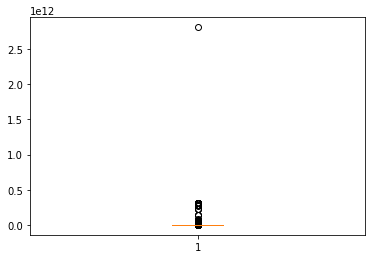

In [11]:
# Verificando a divisão dos dados por meio do boxplot

plt.boxplot(df["Capital"])
plt.show()

In [12]:
# Verificação dos dados máximo e mínimo, além da média

mx = df['Capital'].max()
mn = df['Capital'].min()
mean = df.Capital.mean()

f'Os valores são: máx = {mx}, min = {mn}, média = {round(mean, 2)}'

'Os valores são: máx = 2810842339000, min = 0, média = 286683419.93'

In [13]:
# Verificando e Removendo outliers

df_filtered = df.copy() 

print(df_filtered['Capital'].mean())

df_filtered_mean, df_filtered_std = np.mean(df_filtered['Capital']), np.std(df_filtered['Capital'])
cut_off = df_filtered_std * 3

lower, upper = df_filtered_mean - cut_off, df_filtered_mean + cut_off
df_filtered = df_filtered.loc[~((df_filtered['Capital'] < lower) | (df_filtered['Capital'] > upper))]

# type(idx[0])
df_filtered['Capital'].mean(), df_filtered.count()


286683419.9344


(18756843.028789364,
 CNAE                  99898
 UF                    99898
 Matriz/Filial         99898
 Razao Social          99898
 Capital               99898
 Porte                 99898
 Natureza Juridica     99898
 Situação Cadastral    99898
 dtype: int64)

# Análisando os dados

Inicialmente, faremos uma verificação de capital por empresas, filtrando por estado e situação cadastral

A ideia é entender: quais são os estados com maior capital aplicado em empresas, e se isso se correlaciona com o número de empresas por UF

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
findfont: score(FontEntry(fname='c:\\Users\\sergi\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='c:\\Users\\sergi\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='c:\\Users\\sergi\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 1.05
findfont: score(FontEntry(fname='c:\\Users\\se

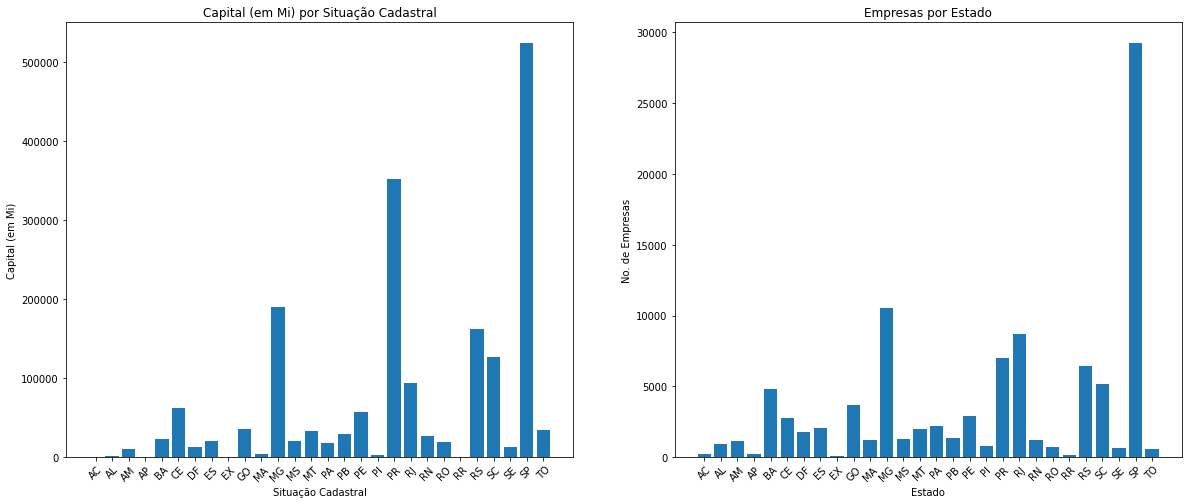

In [14]:
df_filtered['Capital em Milhões'] = df_filtered['Capital'] / 1000000

v1 = df_filtered[['UF', 'Capital em Milhões']].groupby(['UF']).sum('Capital em Milhões')
v2 = df_filtered[['UF', 'Capital']].groupby(['UF']).count()

plt.subplots(figsize=(20,8))

plt.subplot(1,2,1)
plt.bar(v1['Capital em Milhões'].index, v1['Capital em Milhões'])
plt.title("Capital (em Mi) por Situação Cadastral")
plt.xticks(rotation=45)
plt.xlabel("Situação Cadastral")
plt.ylabel("Capital (em Mi)")

plt.subplot(1,2,2)
plt.bar(v2['Capital'].index, v2['Capital'])
plt.title("Empresas por Estado")
plt.xticks(rotation=45)
plt.xlabel("Estado")
plt.ylabel("No. de Empresas")

plt.show()
# v1['Capital'].index

## Respostas

Embora, nesta amostra, tenhamos uma disparidade muito grande para as empresas e capital investido em São Paulo, outros estados com um bom número de empresas não apresentam, em contrapartida, um alto capital na soma por UF

### Agora, veremos quais são as principais naturezas jurídicas cadastras pelo governo

Text(0, 0.5, 'Contagem')

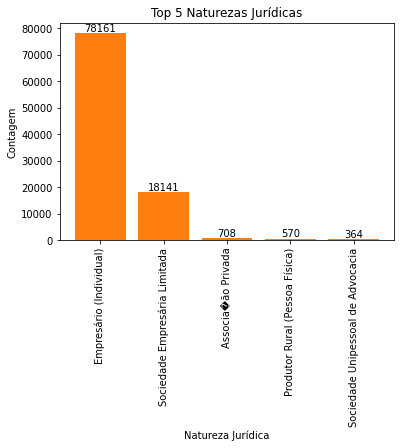

In [15]:
v1 = df_filtered['Natureza Juridica'].value_counts().sort_values(ascending=False).head(5)

fig, ax = plt.subplots()

bars =  ax.bar(v1.index, v1.values)
ax.bar_label(bars)

plt.bar(v1.index, v1.values)
plt.title("Top 5 Naturezas Jurídicas")
plt.xticks(rotation=90)
plt.xlabel("Natureza Jurídica")
plt.ylabel("Contagem")

Podemos ver que, com os dados estando circundados ao perído pré (2018-29), pandemia e pós-pandemia, o número de empresários individuais tem um número 434% maior 

Os dados presentes no dataframe mostram empresas criadas de 2018 em diante, mas quantas se encontram ativas atualmente?

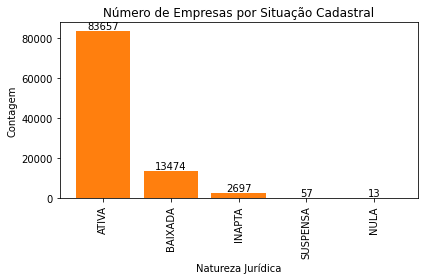

In [16]:
v1 = df_filtered['Situação Cadastral'].value_counts().sort_values(ascending=False)

fig, ax = plt.subplots()

bars =  ax.bar(v1.index, v1.values)
ax.bar_label(bars)

plt.bar(v1.index, v1.values)
plt.title("Número de Empresas por Situação Cadastral")
plt.xticks(rotation=90)
plt.xlabel("Natureza Jurídica")
plt.ylabel("Contagem")

plt.tight_layout()

In [17]:
pct = df_filtered[df_filtered['Situação Cadastral'] == 'ATIVA'].count() / df_filtered.count()
ativo = df_filtered[df_filtered['Situação Cadastral'] == 'ATIVA'].count()

f'Atualmente, das empresas criadas a partir de 2018, {pct[0]}% das empresa estão ativas, num total de {ativo[0]}'

'Atualmente, das empresas criadas a partir de 2018, 0.8374241726561092% das empresa estão ativas, num total de 83657'

In [18]:
# Pré-processamento
# De forma a ajudar o modelo de machine learning a tomar a melhor decisão, iremos transformar os dados quantitativos de capital em intervalos

# df_test = df_filtered.copy()

for n in df_filtered['Capital']:
    if n < 100000:
        df_filtered['Interval'] = 'Menor que 100k'
    elif (n >= 100000) and (n < 500000):
        df_filtered['Interval'] = 'Entre 100k e 500k' 
    elif (n >= 500000) and (n < 1000000):
        df_filtered['Interval'] = 'Entre 500k e 1M' 
    else:
        df_filtered['Interval'] = 'Maior que 1M'


## Conversão de dados categóricos para numéricos

In [19]:
# Aqui estamos convertendo textos para registros numéricos, permitindo que o algoritmo de machine learning leia as colunas

label_encoder = preprocessing.LabelEncoder()

df_ml = df_filtered.copy()
df_ml = df_ml.drop(columns=['CNAE', 'Razao Social', 'Capital', 'Capital em Milhões']) #, inplace=True
df_ml['Situação Cadastral'] = label_encoder.fit_transform(df_ml['Situação Cadastral'])
df_ml['UF'] = label_encoder.fit_transform(df_ml['UF'])
df_ml['Matriz/Filial'] = label_encoder.fit_transform(df_ml['Matriz/Filial'])
df_ml['Interval'] = label_encoder.fit_transform(df_ml['Interval'])
df_ml['Porte'] = label_encoder.fit_transform(df_ml['Porte'])
df_ml['Natureza Juridica'] = label_encoder.fit_transform(df_ml['Natureza Juridica'])
df_ml['Situação Cadastral'] = label_encoder.fit_transform(df_ml['Situação Cadastral'])

df_ml

,UF,Matriz/Filial,Porte,Natureza Juridica,Situação Cadastral,Interval
0,0,1,2,12,0,0
1,0,1,2,12,0,0
2,0,1,2,12,0,0
3,0,1,2,12,0,0
4,0,1,2,12,0,0
...,...,...,...,...,...,...
99994,4,1,0,28,0,0
99995,4,0,2,28,0,0
99997,4,1,2,12,0,0
99998,4,1,2,12,0,0


ValueError: y contains previously unseen labels: [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40]

locator: <matplotlib.ticker.AutoLocator object at 0x0000013BD2C29940>


<AxesSubplot:>

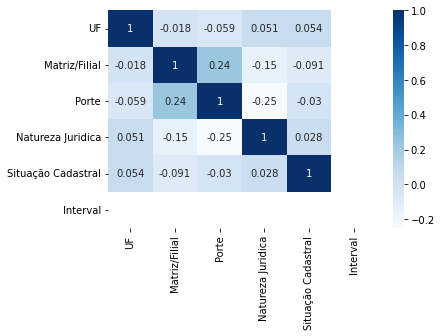

In [20]:
corr = df_ml.corr()

sns.heatmap(corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns, 
        cmap="Blues", 
        annot=True)

# Criação do algoritmo de machine learning

Agora iremos tentar prever a situação cadastral que terá uma empresa de acordo com os atributos colocados acima

In [21]:
#Criando uma lista de algoritmos para comparação e fazendo um split de dados de teste e treino

x = df_ml.drop(columns=['Situação Cadastral'])
y = df_ml['Situação Cadastral']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.25, random_state = 0)

In [22]:
# # Criação dos modelos convencionais:
# lista_modelos = [GaussianNB(),
#                  DecisionTreeClassifier(),
#                  SVC(),
#                  RandomForestClassifier(n_estimators = 1000, max_leaf_nodes=1000),
#                  KNeighborsClassifier(n_neighbors=3),
#                  XGBClassifier()
#                 ]
# for modelo in lista_modelos:
#     modelo.fit(x_train, y_train)

In [23]:
# Com a validação cruzada podemos fazer um double check e verificar se os registros de acurácia se aplicam ao dataset todo

lista_modelos = [GaussianNB(),
                 DecisionTreeClassifier(),
                 SVC(),
                 RandomForestClassifier(n_estimators = 1000, max_leaf_nodes=1000),
                 KNeighborsClassifier(n_neighbors=3),
                 XGBClassifier()
                ]

for modelo in lista_modelos:
    modelo.fit(x_train, y_train)
    val_res_clf = cross_val_score(modelo, x_test, y_test, cv=10)
    print(modelo, val_res_clf.mean())

c:\Users\sergi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


GaussianNB() 0.15147124507776025


c:\Users\sergi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


DecisionTreeClassifier() 0.8456856314046031


c:\Users\sergi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


SVC() 0.8407607784265057


c:\Users\sergi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


RandomForestClassifier(max_leaf_nodes=1000, n_estimators=1000) 0.8458458556993774


c:\Users\sergi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


KNeighborsClassifier(n_neighbors=3) 0.7624884689489677


c:\Users\sergi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...) 0.8460460639236258


In [24]:
# Previsões
previsoes = []
taxa_acerto = []
for modelo in lista_modelos:
    previsoes.append(modelo.predict(x_test))
    taxa_acerto.append(accuracy_score(y_test, previsoes[-1]))

## Métricas de desempenho para os modelos utilizados:

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

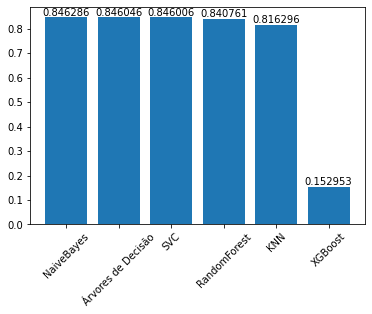

In [25]:
models = ["NaiveBayes", "Árvores de Decisão", "SVC", "RandomForest", "KNN","XGBoost"]
df_res = pd.DataFrame({"Modelos":models, "TxAcerto":taxa_acerto})
df_res = df_res.set_index("Modelos")
grafico = df_res.TxAcerto.sort_values(ascending=False)

fig, ax = plt.subplots()

bars = ax.bar(models, grafico)
ax.bar_label(bars)

plt.xticks(rotation=45)

## Definindo o algoritmo

Como o algoritmo de melhor acerto foi o de Arvore de Decisão (veja a Cross Vaidation junto ao score apresentado no gráfico acima), ele será transportado para ser feito o deploy

Faremos também um detalhamento sobre o modelo, trazendo a média de validação sobre cross validation


In [26]:
Dtree = DecisionTreeClassifier().fit(x_train, y_train)

<AxesSubplot:>

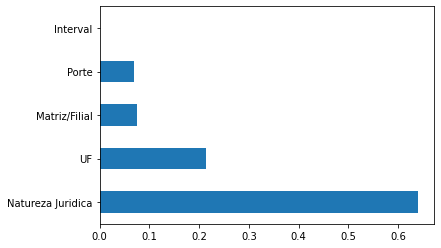

In [27]:
feat_importances = pd.Series(Dtree.feature_importances_, index=x_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [28]:
# salvando o modelo para o deploy em produção

pickle.dump(Dtree, open(pathlib.Path.cwd() / 'clf_pji4.pkl', 'wb'))